In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

In [ ]:
dfa = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_production/data/Copy of Volve production data.xlsx')
dfa.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
df = dfa.copy()
# Select relevant columns
df = df[['DATEPRD','NPD_WELL_BORE_NAME','BORE_OIL_VOL']]

# Rename Columns to more appropriate names
df.rename(columns={'DATEPRD': 'Date',
                   'NPD_WELL_BORE_NAME': 'WellID',
                   'BORE_OIL_VOL': 'Production',
                   }, inplace=True)
df.head()

,Date,WellID,Production
0,2014-04-07,15/9-F-1 C,0.0
1,2014-04-08,15/9-F-1 C,0.0
2,2014-04-09,15/9-F-1 C,0.0
3,2014-04-10,15/9-F-1 C,0.0
4,2014-04-11,15/9-F-1 C,0.0


In [ ]:
# Convert the 'DateColumn' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display the DataFrame with the updated column type
print(df.dtypes)

Date          datetime64[ns]
WellID                object
Production           float64
dtype: object


In [ ]:
# Make Date the index column
df.set_index('Date', inplace=True)

# Sort by date
df.sort_values(by='Date', inplace=True)

In [ ]:
df1 = df.copy()
df1 = df1[df1['WellID'] == '15/9-F-14']
df1.head()

,WellID,Production
Date,,
2008-02-12,15/9-F-14,0.0
2008-02-13,15/9-F-14,0.0
2008-02-14,15/9-F-14,0.0
2008-02-15,15/9-F-14,0.0
2008-02-16,15/9-F-14,0.0


In [ ]:
# Feature engineering
df1['Year'] = df1.index.year
df1['Month'] = df1.index.month
df1['Day'] = df1.index.day

# Remove the WellID column
df1.drop(columns=['WellID'], inplace=True)

# Filter off some unwanted data
df1 = df1[(df1['Year'] <= 2014)&(df1['Production'] != 0)]

df1.head()

,Production,Year,Month,Day
Date,,,,
2008-07-13,1735.26,2008,7,13
2008-07-14,592.36,2008,7,14
2008-07-15,2532.21,2008,7,15
2008-07-16,3030.71,2008,7,16
2008-07-17,3288.08,2008,7,17


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Production'].values.reshape(-1, 1))
scaled_data

array([[0.30690399],
       [0.10426466],
       [0.44820543],
       ...,
       [0.05113589],
       [0.06591408],
       [0.06197795]])

In [ ]:
# Prepare the training data
look_back = 10  # Number of previous time steps to use as input
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [ ]:
# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Train test split
# Split the data into training and testing sets
split_index = int(len(df1) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
print(X_train.shape)
print(X_test.shape)

(1733, 10, 1)
(424, 10, 1)


In [ ]:
y_train = y[:split_index]
y_test = y[split_index:]
print(y_train.shape)
print(y_test.shape)

(1733,)
(424,)


In [ ]:
# # Build the RNN model
# model_rnn = Sequential()
# model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model_rnn.add(Dense(units=25, activation='relu'))
# model_rnn.add(Dense(units=1, activation='linear'))


# Build the RNN model
model_rnn = Sequential()
model_rnn.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(SimpleRNN(units=50, activation='relu'))
model_rnn.add(Dense(units=25, activation='relu'))
model_rnn.add(Dense(units=1, activation='linear'))
# Compile the Model
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Train the Model
model_rnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
44/44 [==============================] - 2s 11ms/step - loss: 0.0194 - val_loss: 0.0012
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0017
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 9.0483e-04
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 9.3285e-04
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 8.1194e-04
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 8.2567e-04
Epoch 8/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 8.4373e-04
Epoch 9/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0017
Epoch 10/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0085 - val_l

In [ ]:
# # Evaluate the Model

loss = model_rnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

14/14 [==============================] - 0s 2ms/step - loss: 0.0073
Test Loss: 0.007283812388777733


In [ ]:
# Make predictions
predictions = model_rnn.predict(X_test)

# Display some predictions
print(predictions[:5])

14/14 [==============================] - 0s 2ms/step
[[0.15899485]
 [0.15102533]
 [0.15105672]
 [0.14865431]
 [0.1510699 ]]


In [ ]:
# Evaluate the model
train_predict_r = model_rnn.predict(X_train)
test_predict_r = model_rnn.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [ ]:
# Transform the predictions back to original scale
train_predict = scaler.inverse_transform(train_predict_r)
test_predict = scaler.inverse_transform(test_predict_r)
mean_absolute_error(y_train, train_predict)

2228.280801003071

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predict)
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 872.3803176415139
Mean Squared Error (MSE): 787569.3854014337
Root Mean Squared Error (RMSE): 887.4510608486722


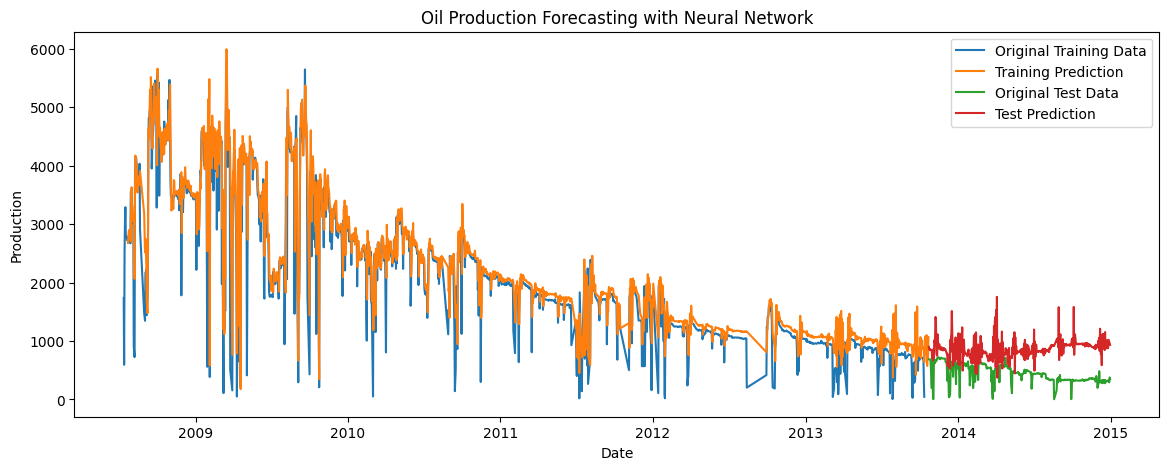

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(df1.index[:len(train_predict)], df1['Production'].iloc[:len(train_predict)], label='Original Training Data')
plt.plot(df1.index[look_back:len(train_predict) + look_back], train_predict, label='Training Prediction')

# Plot testing data
plt.plot(df1.index[len(train_predict) + (look_back):], df1['Production'].iloc[len(train_predict) + (look_back):], label='Original Test Data')
plt.plot(df1.index[len(train_predict) + (look_back):], test_predict, label='Test Prediction')

plt.title('Oil Production Forecasting with Neural Network')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
import pickle

model_rnn.save('/content/drive/MyDrive/Colab Notebooks/well_production/models/rnn_model.h5')

# Load the model using load_model
model_rnn_loaded = load_model('/content/drive/MyDrive/Colab Notebooks/well_production/models/rnn_model.h5')